In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,6]

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


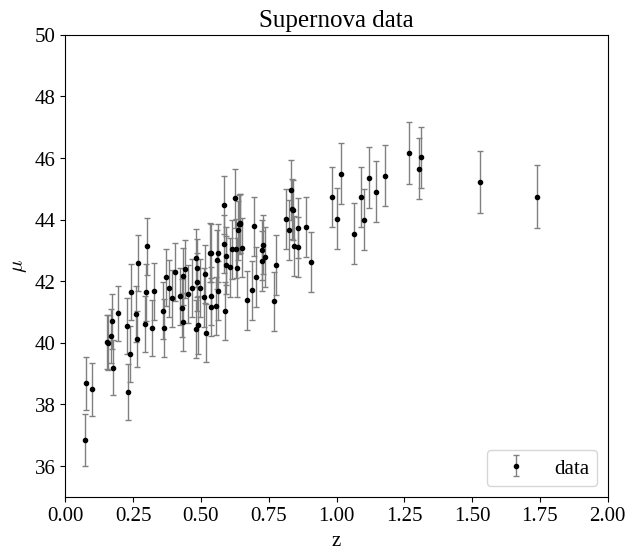

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

i_ord=z_sample.argsort()

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Supernova data')

plt.show()

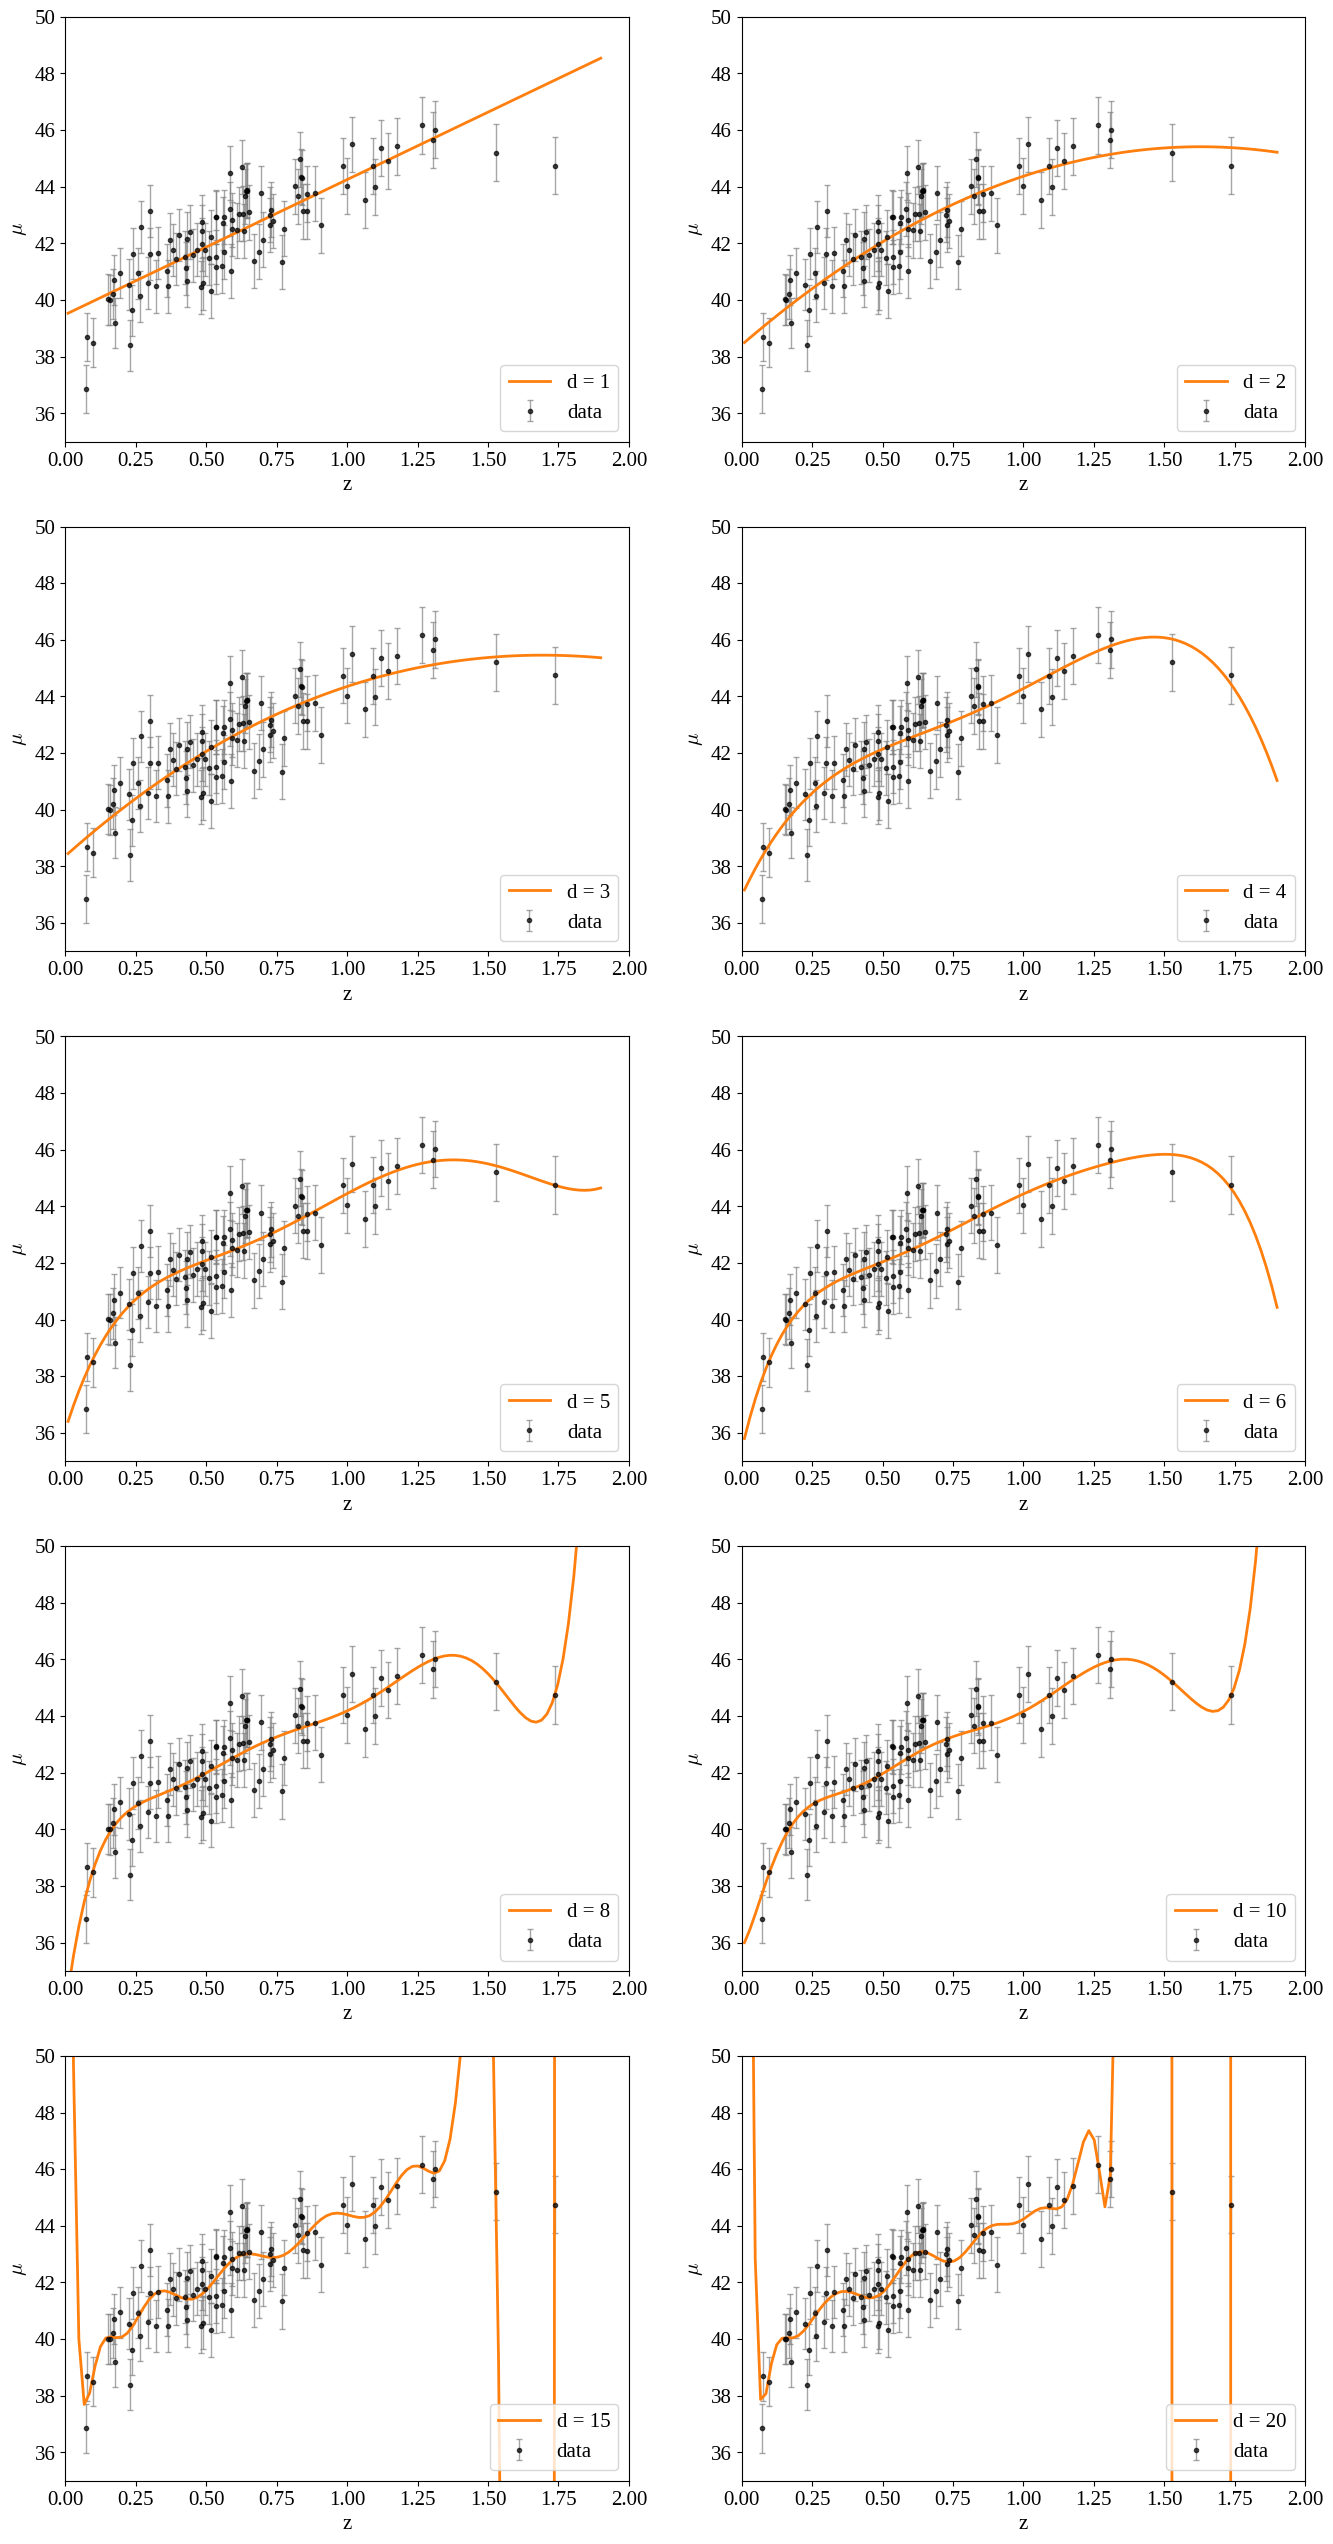

In [3]:
z_grid=np.linspace(0.01, 1.9, 100)

fig = plt.figure(figsize=(16, 32))

for i, d in enumerate([1,2,3,4,5,6,8,10,15,20]):
    ax = fig.add_subplot(5,2,1+i)

    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.7, label='data')
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend(loc='lower right')
    plt.xlim(0,2)
    plt.ylim(35,50)

    model = PolynomialRegression(d)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)

    y_pred = model.predict(z_grid[:,np.newaxis])
    
    plt.plot(z_grid, y_pred, lw=2, c='C1', label="d = %i" % d)
    plt.legend(loc='lower right')

plt.show()

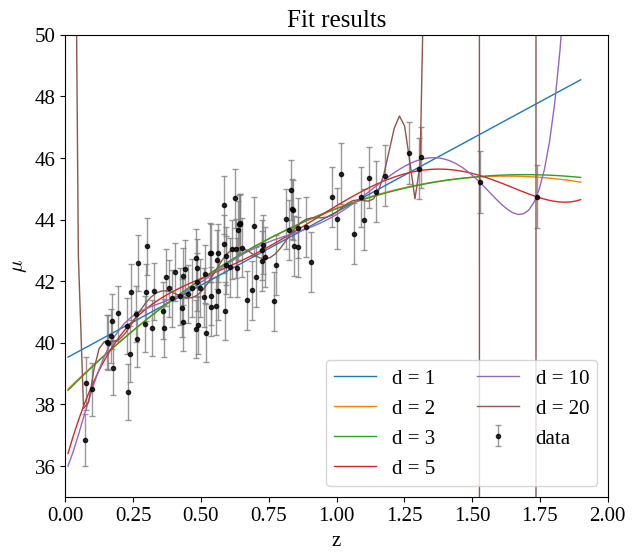

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, alpha=0.8, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")  
plt.xlim(0,2)
plt.ylim(35,50)

for i, d in enumerate([1,2,3,5,10,20]):

    model = PolynomialRegression(d)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)

    y_pred = model.predict(z_grid[:,np.newaxis])
    
    plt.plot(z_grid, y_pred, lw=1, label="d = %i" % d)
    
plt.legend(loc='lower right', ncol=2)
plt.title('Fit results')
plt.show()

In [5]:
#cross validation

def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)/ len(y))


def errors_cv(X, y, dy, clf, cv, random_state):
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        dy_train, dy_cv = dy[train_index], dy[cv_index]
        
        clf.fit(X_train, y_train, dy_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
    
    return np.median(cverr), np.median(trainerr)

In [6]:
deg = np.linspace(1, 20, 20, dtype=int)

CVerr=[]
train_err=[]

for d in deg:
    polyfit = PolynomialRegression(d)
    cverr, trainerr = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, polyfit, 7, random_state=10)
    CVerr.append(cverr)
    train_err.append(trainerr)

d_best = deg[CVerr == min(CVerr)][0]
print('Best degree:', d_best)

Best degree: 2


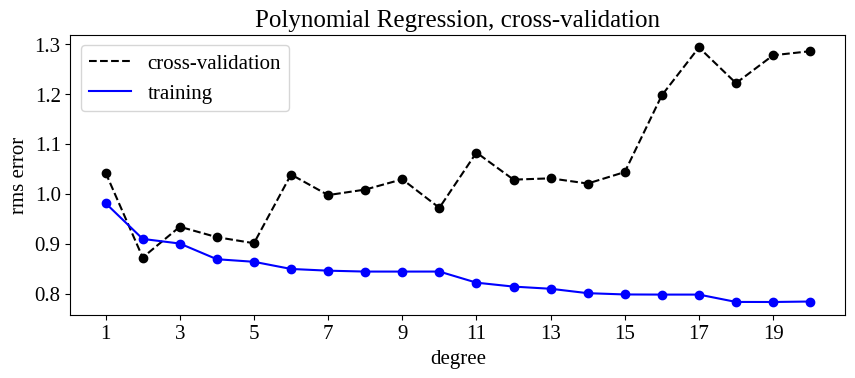

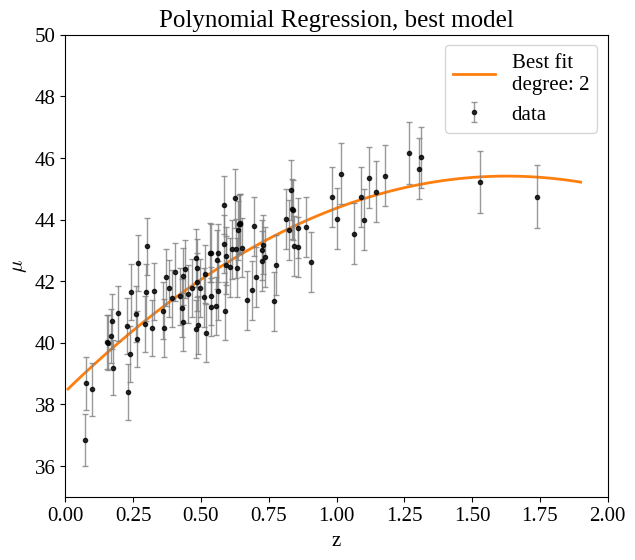

In [7]:
#print the best fit

fig = plt.figure(figsize=(10, 8))

# Plot cross-validation result
ax = fig.add_subplot(211)
plt.scatter(deg, CVerr, c='black')
plt.scatter(deg, train_err, c='blue')
plt.plot(deg, CVerr, '--', c='black', label='cross-validation')
plt.plot(deg, train_err, '-', c='blue', label='training')
tick=np.arange(1,20,2)
plt.xticks(tick)
plt.xlabel('degree')
plt.ylabel('rms error')
plt.legend()
plt.title('Polynomial Regression, cross-validation')
plt.show()

# plot best model
poly = PolynomialRegression(d_best)
poly.fit(z_sample[:, np.newaxis], mu_sample, dmu)
yfit = poly.predict(z_grid[:,np.newaxis])

ax = fig.add_subplot(212)
plt.plot(z_grid, yfit, lw=2, c='C1', label='Best fit\ndegree: %i' %d_best)  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, alpha=0.8, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")  
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Polynomial Regression, best model')
plt.legend()
plt.show()

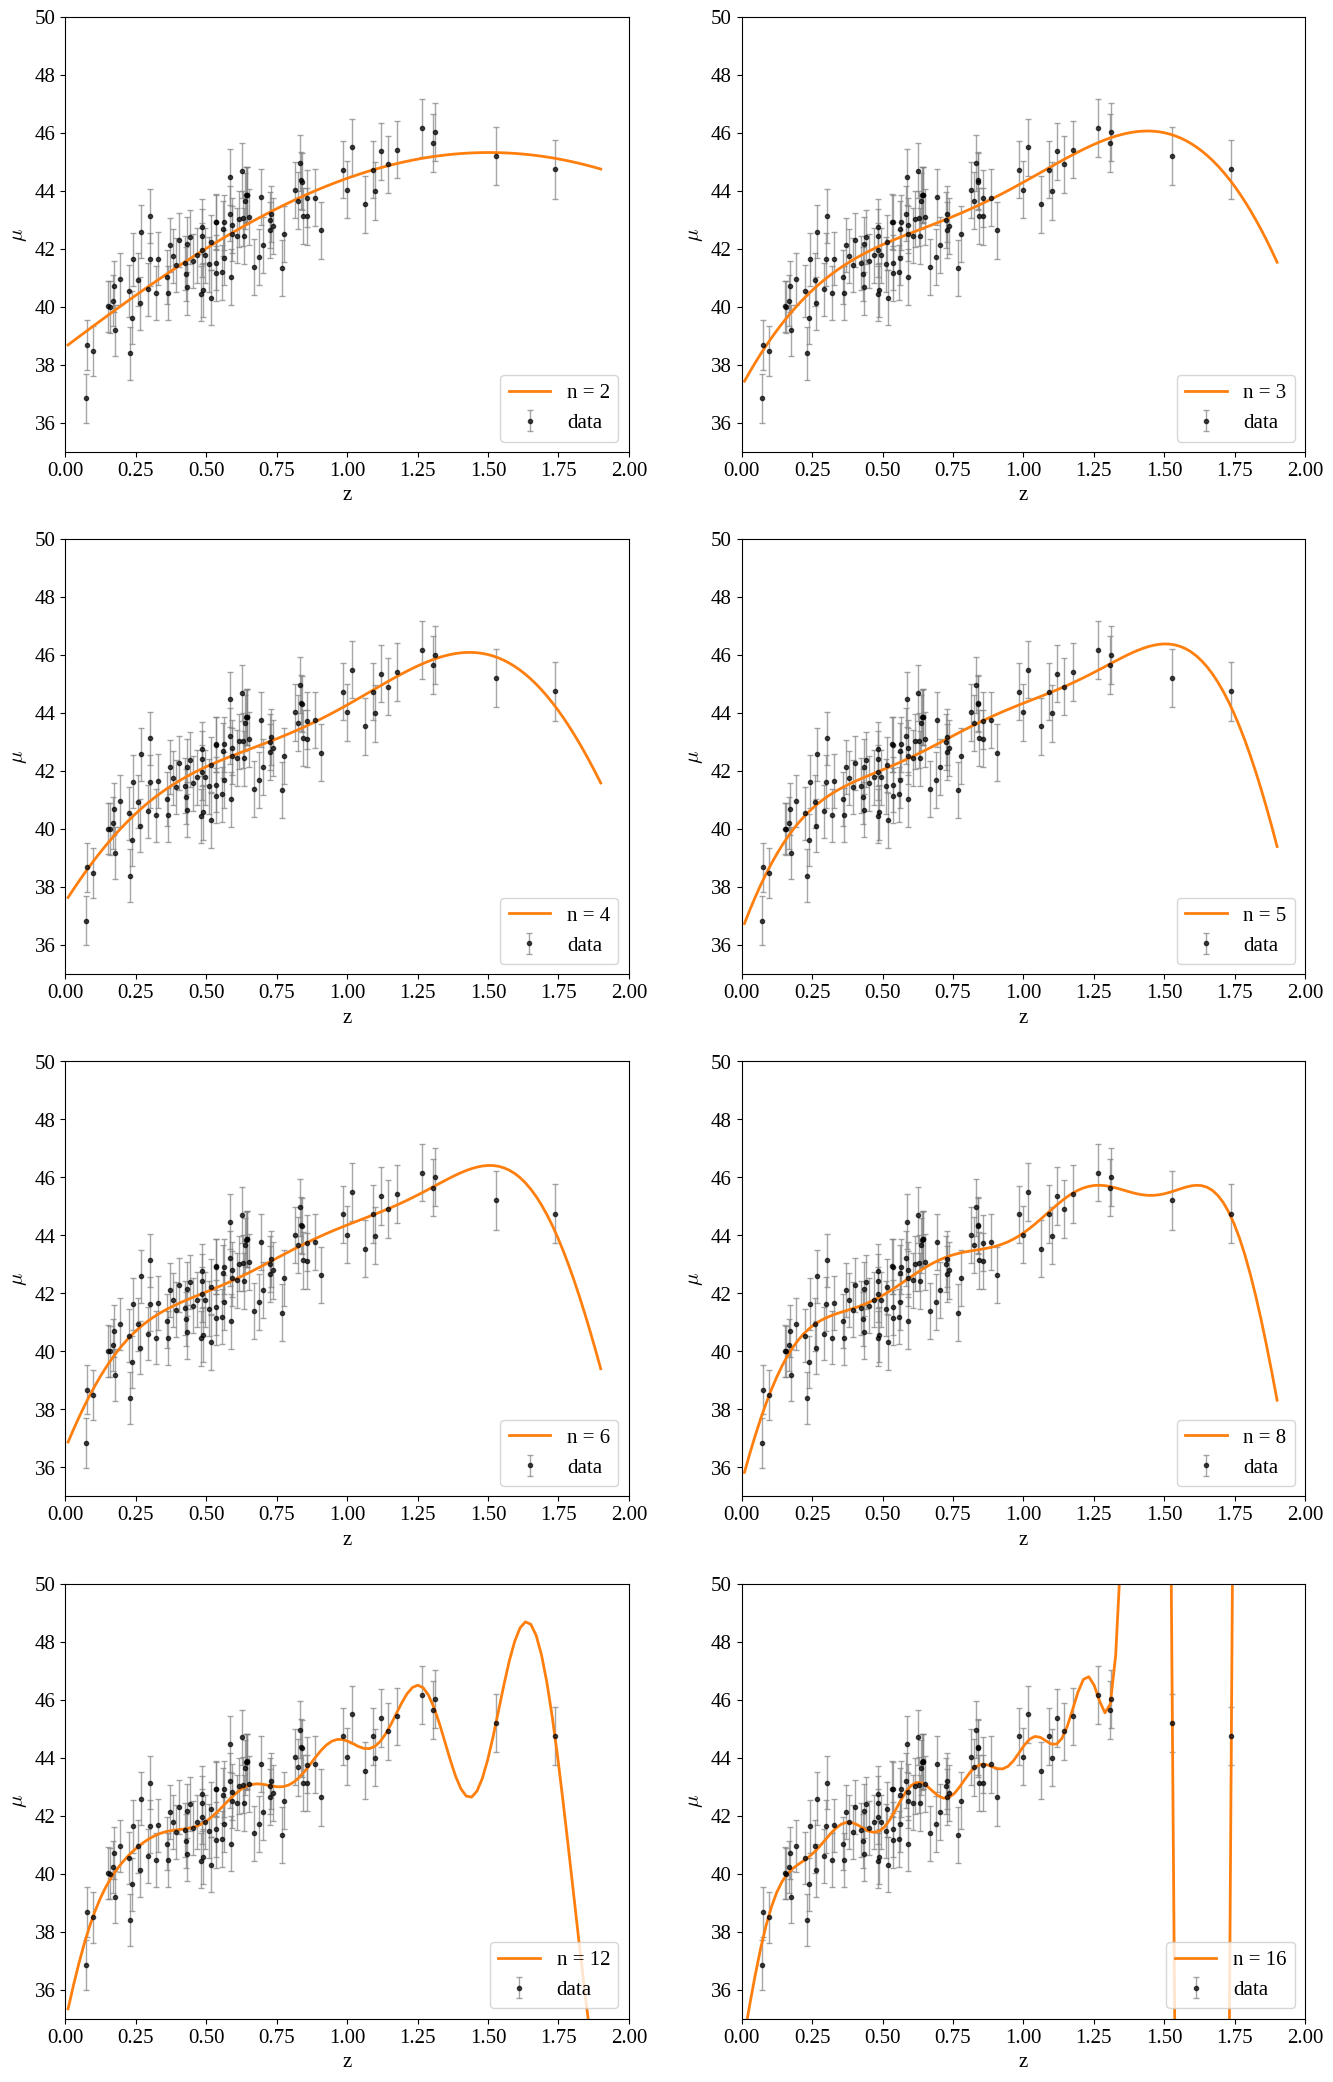

In [8]:
# gaussian bases regression

#try different number of gaussians

fig = plt.figure(figsize=(16, 26))

for i, n in enumerate([2,3,4,5,6,8,12,16]):
    ax = fig.add_subplot(4,2,1+i)

    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.7, label='data')
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend(loc='lower right')
    plt.xlim(0,2)
    plt.ylim(35,50)
    
    Xgrid_fit=np.linspace(min(z_sample), max(z_sample), n)
    
    sigma_test=Xgrid_fit[1]-Xgrid_fit[0]
    
    model = BasisFunctionRegression('gaussian', mu=Xgrid_fit[:,np.newaxis], sigma=sigma_test)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)

    y_pred = model.predict(z_grid[:,np.newaxis])
    
    plt.plot(z_grid, y_pred, lw=2, c='C1', label="n = %i" % n)
    plt.legend(loc='lower right')

plt.show()

In [9]:
#try to find the best number of gaussians

num = np.linspace(2, 15, 14, dtype=int)

CVerr_base=[]
train_err_base=[]

for n in num:
    
    Xgrid_fit=np.linspace(min(z_sample), max(z_sample), n)
    
    sigma_test=Xgrid_fit[1]-Xgrid_fit[0]
    
    model = BasisFunctionRegression('gaussian', mu=Xgrid_fit[:,np.newaxis], sigma=sigma_test)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    
    cverr, trainerr = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, model, 7, random_state=10)
    CVerr_base.append(cverr)
    train_err_base.append(trainerr)

n_best = num[CVerr_base == min(CVerr_base)][0]
print('Best number:', n_best)

Best number: 2


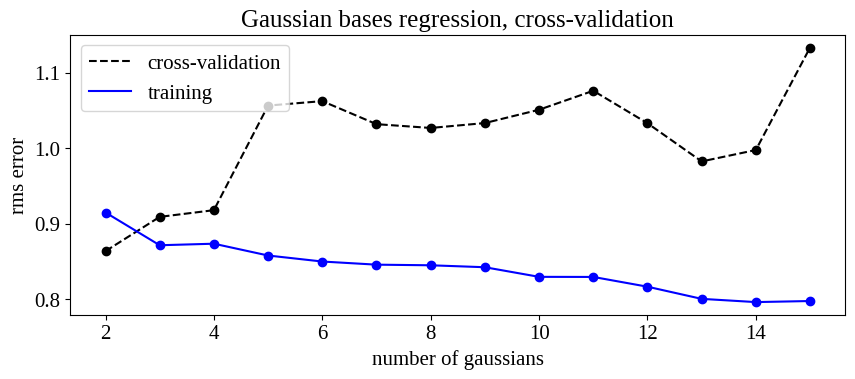

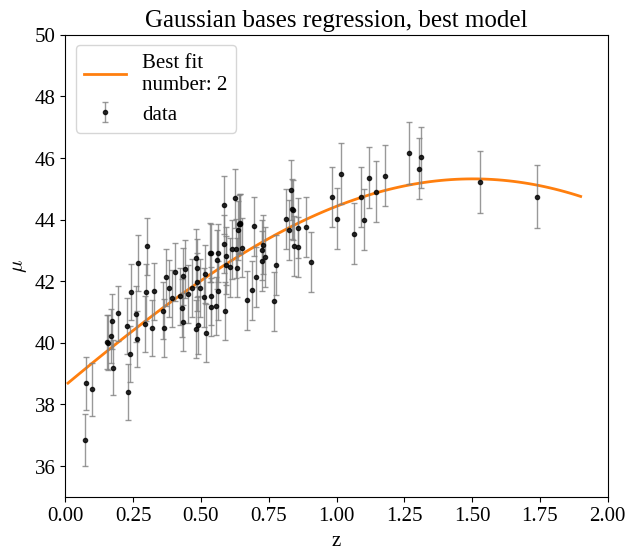

In [10]:
#print the best fit

fig = plt.figure(figsize=(10, 8))

# Plot cross-validation result
ax = fig.add_subplot(211)
plt.scatter(num, CVerr_base, c='black')
plt.scatter(num, train_err_base, c='blue')
plt.plot(num, CVerr_base, '--', c='black', label='cross-validation')
plt.plot(num, train_err_base, '-', c='blue', label='training')
tick=np.arange(2,15,2)
plt.xticks(tick)
plt.xlabel('number of gaussians')
plt.ylabel('rms error')
plt.legend(loc='upper left')
plt.title('Gaussian bases regression, cross-validation')
plt.show()

# plot best model

Xgrid_fit=np.linspace(min(z_sample), max(z_sample), n_best)
    
sigma_test=Xgrid_fit[1]-Xgrid_fit[0]
    
model = BasisFunctionRegression('gaussian', mu=Xgrid_fit[:,np.newaxis], sigma=sigma_test)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)

y_fit = model.predict(z_grid[:,np.newaxis])

ax = fig.add_subplot(212)
plt.plot(z_grid, y_fit, lw=2, c='C1', label='Best fit\nnumber: %i' %d_best)  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, alpha=0.8, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")  
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Gaussian bases regression, best model')
plt.legend()
plt.show()

In [11]:
#but in this case we have 2 parameters, the number of the gaussians and the sigma

#let's use cross validation to find the best parameters

N = np.linspace(2, 15, 14, dtype=int)    # number of gaussians
sigma = np.linspace(0.01, 2., 100)       # width

train_err_base2 = np.zeros((len(N), len(sigma)))
CVerr_base2 = np.zeros((len(N), len(sigma)))

for i,n in enumerate(N):
    for j,s in enumerate(sigma):
        basis_centers = np.linspace(min(z_sample), max(z_sample), n)[:, np.newaxis]
        basis = BasisFunctionRegression('gaussian', mu=basis_centers, sigma=s)
        CVerr_base2[i][j], train_err_base2[i][j] = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, basis, 7,
                                                           random_state=10)
        
best = np.where(CVerr_base2 == np.min(CVerr_base2))

N_best2 = int(N[best[0]])
sigma_best2 = float(sigma[best[1]])
print('Best number of gaussians:', N_best2, '\nWith sigma: ', round(sigma_best2,3))

Best number of gaussians: 3 
With sigma:  0.412


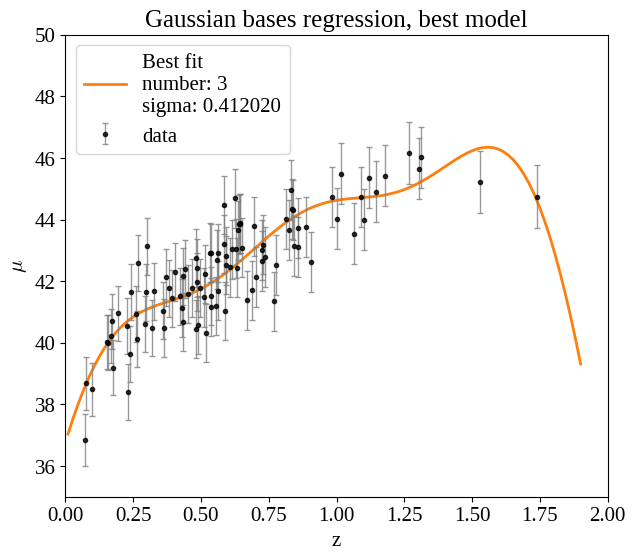

In [12]:
Xgrid_fit=np.linspace(min(z_sample), max(z_sample), N_best2)
    
sigma_test=sigma_best2
    
model_best = BasisFunctionRegression('gaussian', mu=Xgrid_fit[:,np.newaxis], sigma=sigma_test)
model_best.fit(z_sample[:,np.newaxis], mu_sample, dmu)

y_fit = model_best.predict(z_grid[:,np.newaxis])

plt.plot(z_grid, y_fit, lw=2, c='C1', label='Best fit\nnumber: %i\nsigma: %f' %(N_best2,sigma_test))  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, alpha=0.8, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")  
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Gaussian bases regression, best model')
plt.legend()
plt.show()

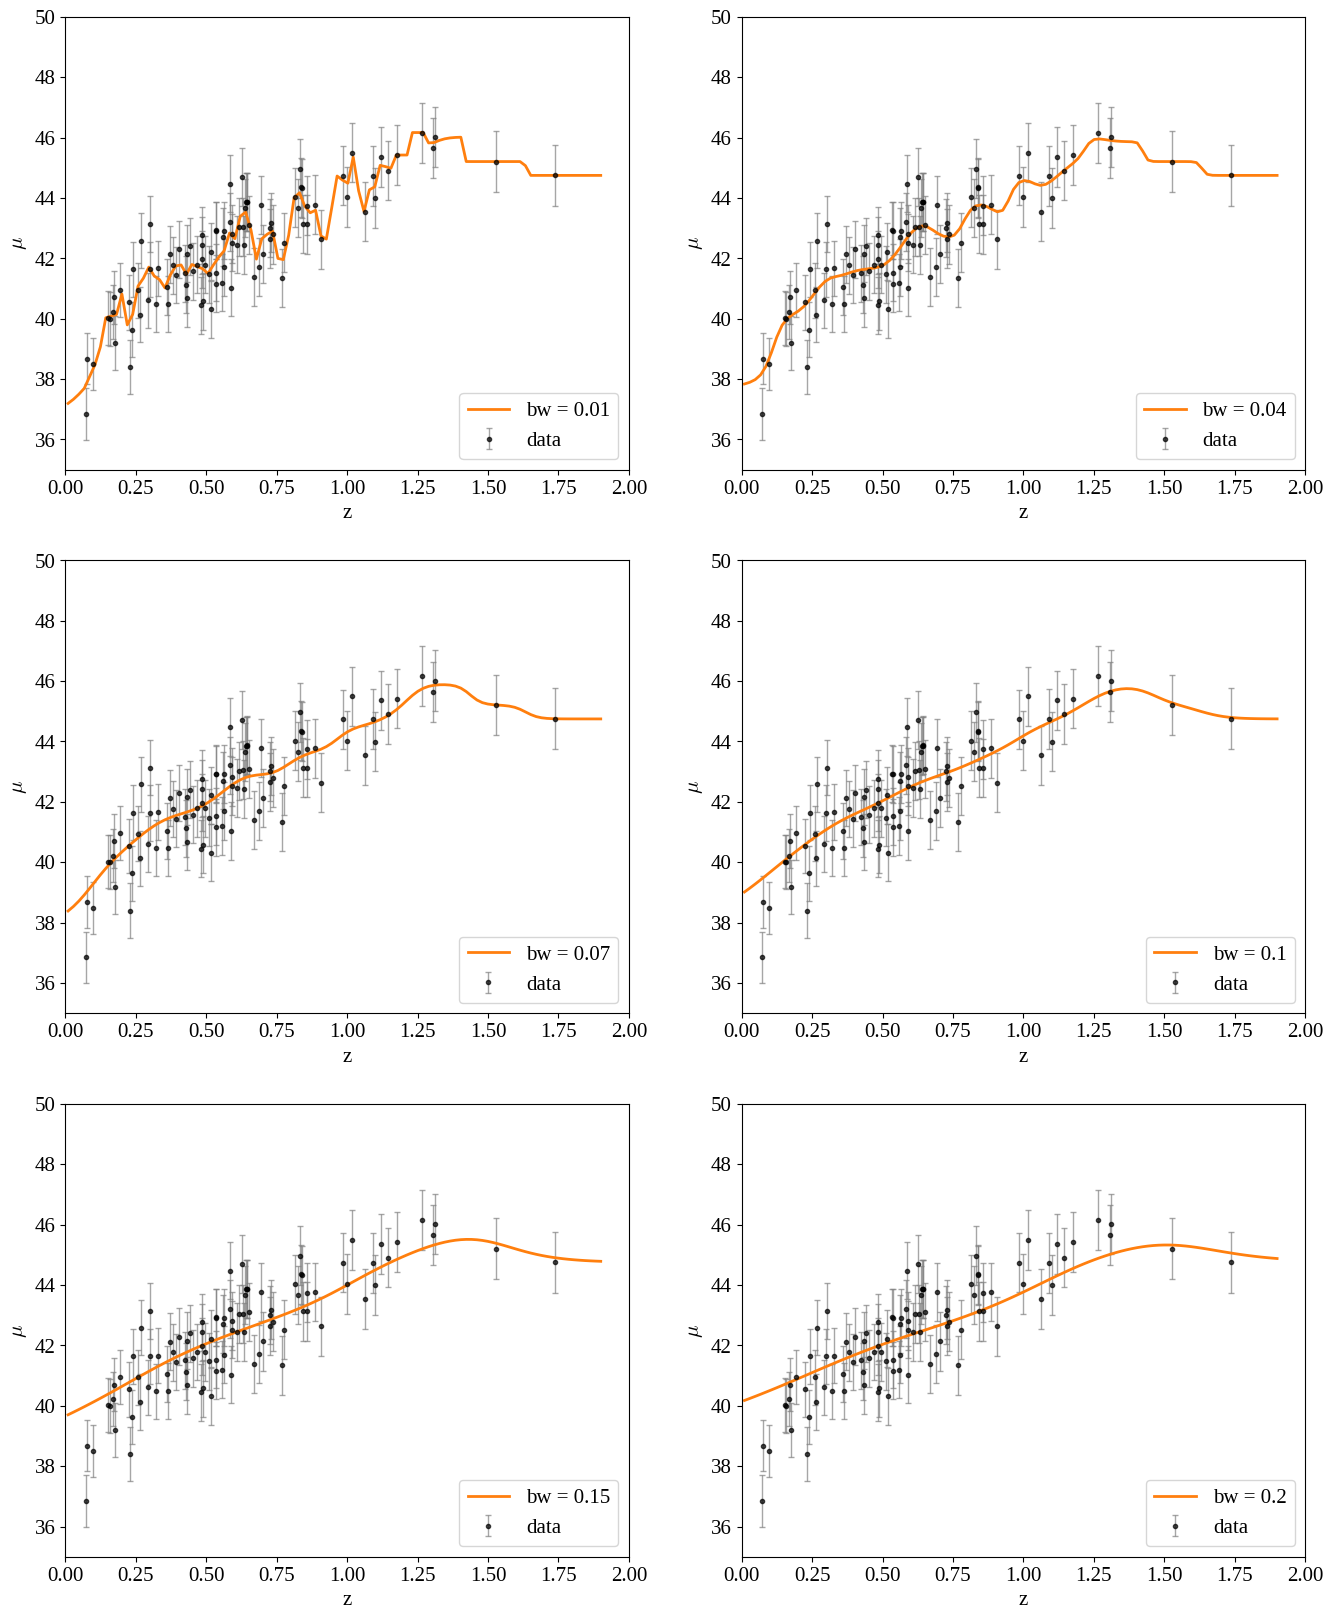

In [13]:
#kernel regression

fig = plt.figure(figsize=(16, 20))

for i, bw in enumerate([0.01,0.04,0.07,0.1,0.15,0.2]):
    ax = fig.add_subplot(3,2,1+i)

    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.7, label='data')
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend(loc='lower right')
    plt.xlim(0,2)
    plt.ylim(35,50)
    
    model_kernel = NadarayaWatson(kernel='gaussian', h=bw)
    model_kernel.fit(z_sample[:,np.newaxis], mu_sample, dmu)

    y_pred = model_kernel.predict(z_grid[:,np.newaxis])
    
    plt.plot(z_grid, y_pred, lw=2, c='C1', label="bw = %s" % bw)
    plt.legend(loc='lower right')

plt.show()

In [14]:
#cross validation

bandwidth = np.linspace(0.01, 0.2, 20)

CVerr_kernel=[]
train_err_kernel=[]

for bw in bandwidth:
    
    model_kernel = NadarayaWatson(kernel='gaussian', h=bw)
    cverr, trainerr = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, model_kernel, 5, random_state=1)
    CVerr_kernel.append(cverr)
    train_err_kernel.append(trainerr)

bw_best = bandwidth[CVerr_kernel == min(CVerr_kernel)][0]
print('Best bandwidth:', bw_best)

Best bandwidth: 0.08


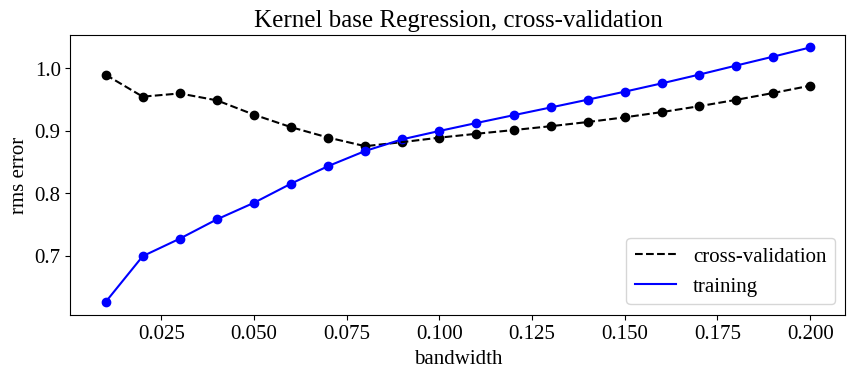

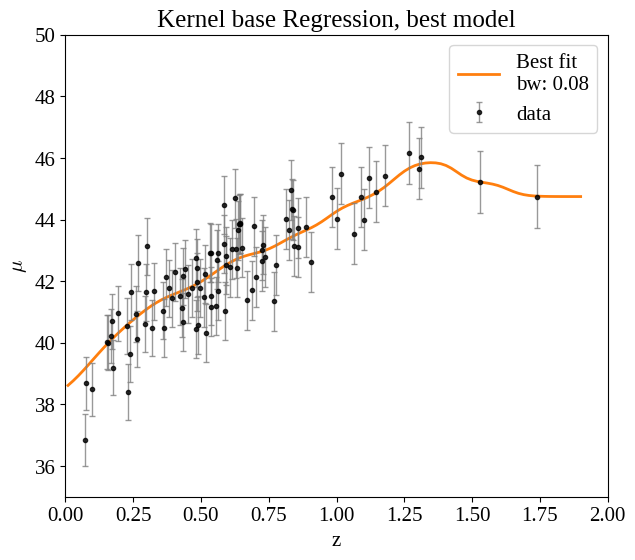

In [20]:
#print the best fit

fig = plt.figure(figsize=(10, 8))

# Plot cross-validation result
ax = fig.add_subplot(211)
plt.scatter(bandwidth, CVerr_kernel, c='black')
plt.scatter(bandwidth, train_err_kernel, c='blue')
plt.plot(bandwidth, CVerr_kernel, '--', c='black', label='cross-validation')
plt.plot(bandwidth, train_err_kernel, '-', c='blue', label='training')
plt.xlabel('bandwidth')
plt.ylabel('rms error')
plt.legend()
plt.title('Kernel base Regression, cross-validation')
plt.show()

# plot best model

model_kernel = NadarayaWatson(kernel='gaussian', h=bw_best)
model_kernel.fit(z_sample[:,np.newaxis], mu_sample, dmu)

y_fit = model_kernel.predict(z_grid[:,np.newaxis])

ax = fig.add_subplot(212)
plt.plot(z_grid, y_fit, lw=2, c='C1', label='Best fit\nbw: %s' %bw_best)  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, alpha=0.8, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")  
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Kernel base Regression, best model')
plt.legend()
plt.show()

In [16]:
def learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, clf):
    cverr_dbest =[]
    trainerr_dbest =[]
    N = np.arange(1, len(X_train))

    for n in N:
    
        clf.fit(X_train[:n][:,np.newaxis], y_train[:n], dy_train[:n])
        cverr_dbest.append(rms_error(X_cv[:,np.newaxis], y_cv, clf))
        trainerr_dbest.append(rms_error(X_train[:n][:,np.newaxis], y_train[:n], clf))

    plt.plot(N, cverr_dbest, label='cv')
    plt.plot(N, trainerr_dbest, label='train')
    
    plt.xlabel('train size')
    plt.ylabel('rms error')
    plt.legend()
    
    return 0;

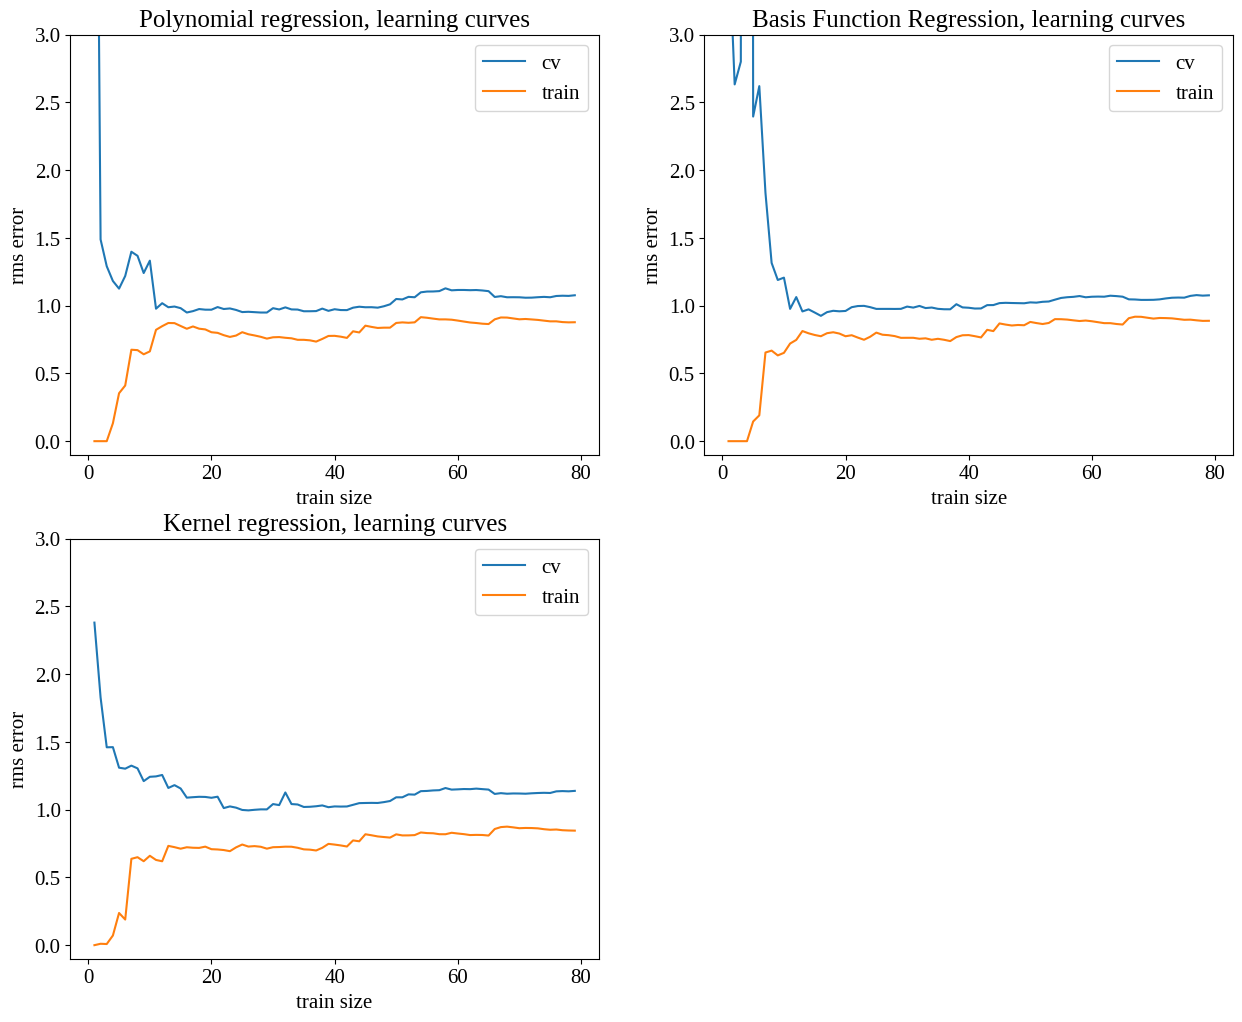

In [17]:
#learning curves

best_poly=PolynomialRegression(d_best)

Xgrid_fit=np.linspace(min(z_sample), max(z_sample), N_best2)
best_base = BasisFunctionRegression('gaussian', mu=Xgrid_fit[:,np.newaxis], sigma=sigma_best2)

best_kernel = NadarayaWatson(kernel='gaussian', h=bw_best)


X_train, X_cv, y_train, y_cv, dy_train, dy_cv = train_test_split(z_sample, mu_sample, dmu, test_size=20, 
                                                                 random_state=1)

fig = plt.figure(figsize=(15,12))


# polynomial regression
ax1 = plt.subplot(221)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, best_poly)
plt.title('Polynomial regression, learning curves')
plt.ylim(-0.1,3);


# basis function regression
ax2 = plt.subplot(222)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, best_base)
plt.title('Basis Function Regression, learning curves')
plt.ylim(-0.1,3);


# kernel regression
ax3 = plt.subplot(223)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, best_kernel)
plt.title('Kernel regression, learning curves')
plt.ylim(-0.1,3);